---
title: "Gaussian Processes and Gaussian Process Regression" 
date: last-modified 
author: "John Waczak" 
body-header: last-modified 
format: 
    html: 
        html-math-method: katex

reference-location: margin 
citation-location: margin
---


# Introduction 

The following is based on the book **Gaussian Processes for Machine Learning** by *Carl Edward Rasmussen and Christopher K. I. Williams*. You can find the free online book [here](https://gaussianprocess.org/gpml/).[^1] 

[^1]: Carl Edward Rasmussen and Christopher K. I. Williams; The MIT Press, 2006. ISBN 0-262-18253-X. 

To explain/derive the Gaussian Process model for regression, let's first consider a motivated example: **Linear Regression**. We will use this guiding example to derive GRP from a *weight space view*. After this derivation, will suggest a simpler, but more abstract derivation using a *function space view*. 

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/gitrepos/machine-learning/MLJGP.jl/notebooks`


In [2]:
using LinearAlgebra
using Distributions
using Random
using Plots

First let's set up some data we can use for training: 

# Weight-Space View

## Nomenclature

We consider a dataset $\mathcal{D}$ with $n$ observations
\begin{equation}
    \mathcal{D} = \Big\{ (\mathbf{x}_i, y_i) \;\Big\vert \; i = 1,...,n\Big\}
\end{equation}

- $\mathbf{x}_i$ is the $i^{th}$ D-dimensional input (feature) vector 
- $y_i$ is the $i^{th}$ target

Linear regression is easily understood in terms of *linear algebra*. We therefore collect our dataset $\mathcal{D}$ into a $D \times n$ dimensional [**Design Matrix**](https://en.wikipedia.org/wiki/Design_matrix). Note that we have used a transposed definition (features are rows, records are columns) as Julia is a column-major language (like Matlab & Fortran).

\begin{equation}
    X := \begin{pmatrix} 
    \vdots & \vdots & & \vdots \\ 
    \mathbf{x}_1 & \mathbf{x}_2 & ... & \mathbf{x}_n \\
    \vdots & \vdots & & \vdots 
    \end{pmatrix}
\end{equation}

and our targets into a target vector

\begin{equation}
    \mathbf{y} := (y_1, ..., y_n)
    \end{equation}
    so that the full training set becomes 
    \begin{equation}
    \mathcal{D} := (X, \mathbf{y})
\end{equation}


## Standard Linear Regression

Standard linear regression is a model of the form
\begin{equation}
    f(\mathbf{x}) = \mathbf{x}^T\mathbf{w}
\end{equation}
where $\mathbf{w}$ is the $D$-dimensional vector of weights. By minimizing the mean-squared-error between our model and targets, one can show that the optimal weights are given by 
\begin{equation}
    \mathbf{w} = (XX^T)^{-1}X\mathbf{y}
\end{equation}

::: {.callout-note collapse=true}

This can also be easily obtained geometrically by finding the vector with the shortest distance to the hyperplane defined by the column space of $X$. This corresponds to solving the [**normal equations**](https://en.wikipedia.org/wiki/Ordinary_least_squares#Normal_equations) 
    \begin{equation}
        XX^T \mathbf{w} = X\mathbf{y}
    \end{equation}
:::

The following demonstrates this procedure on a simple dataset

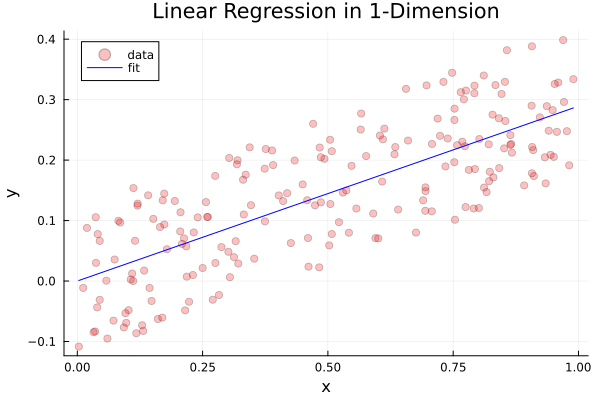

In [3]:
X = rand(200)
y = 0.3 .* X .+ 0.25 .* (rand(200) .- 0.5)
X = X'

w = (X*X')\(X*y)
ypred = X'*w

plot(X', y, 
    seriestype=:scatter,
    color=:red, alpha=0.25, 
    label="data")

plot!(X', ypred, color=:blue, label="fit")
xlabel!("x")
ylabel!("y")
title!("Linear Regression in 1-Dimension")

::: {.callout-note collapse=true} 

We can also fit a y-intercept (aka *bias*) by augmenting the design matrix $X$ to contain an extra row with all `1`'s, i.e. 
\begin{equation}
    X[D+1, :] = (1, ..., 1)
\end{equation}

:::

## Making it Bayesian 

Standard lienar regression assumes that are data $\mathcal{D}$ are perfect but we can clearly see that the above data are noisy. To account for this, we need to make our model *Bayesian* by augmenting it to consider measurement error. We define
\begin{align}
    f(\mathbf{x}) &= \mathbf{x}^T\mathbf{w} \\ 
    \mathbf{y} &= f(\mathbf{x}) + \mathbf{\epsilon} \\ 
    \mathbf{\epsilon} &\sim \mathcal{N}(0, \sigma_n^2)
\end{align}
or, in words, our observed values differ from the *truth* by identically, independently, distributed Gaussian noise with mean $0$ and variance $\sigma_n^2$. The assumption that the noise is i.i.d. is critical because it allows us to simplify the *likelihood* function by separating out each individual contribution by our datapoints: 
\begin{align} 
    p(\mathbf{y}\vert X,\mathbf{w}) &:= \prod\limits_i^n p(\mathbf{y}_i \vert \mathbf{x}_i, \mathbf{w}) \\
    &= \prod\limits_i^n \frac{1}{\sqrt{2\pi\sigma_n^2}}\exp\left( -\dfrac{(\mathbf{y}_i-\mathbf{x}_i^T\mathbf{w})^2}{2\sigma_n^2}\right)\\
    &= \dfrac{1}{(2\pi\sigma_n^2)^{n/2}}\exp\left( -\frac{1}{2\sigma_n^2}\lvert \mathbf{y} - X^T\mathbf{w}\rvert^2 \right) \\
    &= \mathcal{N}\left(X^T\mathbf{w}, \sigma_n^2I\right)
\end{align} 


To perform inference with this updated model, we apply Baye's Rule, that is: 

\begin{equation}
    p(\mathbf{w}\vert \mathbf{y}, X) = \dfrac{p(\mathbf{y}\vert X, \mathbf{w})p(\mathbf{w})}{p(\mathbf{y}\vert X)}
\end{equation}
where 

- $p(\mathbf{w}\vert \mathbf{y}, X)$ is the **posterior distribution** 
- $p(\mathbf{y}\vert X, \mathbf{w})$ is the **likelihood**
- $p(\mathbf{w})$ is the **prior distribution**
- $p(\mathbf{y} \vert X)$ is the **marginal likelihood**, i.e. the normalization constant

It is now that the utility of choosing gaussian distributions  for our likelihood and prior becomes clear... 
\begin{align}
    p(\mathbf{w}\vert\mathbf{y},X) &\propto \exp\left(-\frac{1}{2\sigma_n^2}(\mathbf{y}-X^T\mathbf{w})^T(\mathbf{y}-X^T\mathbf{w}) \right)\exp\left(-\frac{1}{2}\mathbf{w}^T\Sigma_p^{-1}\mathbf{w}\right)
    \end{align}
    Taking the log and expanding leads to
    \begin{align}
    \log(p(\mathbf{w}\vert \mathbf{y}, X))&= \frac{1}{2}\left[ \frac{1}{\sigma_n^2}\mathbf{y}^T\mathbf{y} - \frac{1}{\sigma_n^2}\mathbf{y}^TX^T\mathbf{w} - \frac{1}{\sigma_n^2}\mathbf{w}^TX\mathbf{y} + \frac{1}{\sigma_n^2}\mathbf{w}^TXX^T\mathbf{w} + \mathbf{w}^T\Sigma_p^{-1}\mathbf{w}\right] \\
    &= \frac{1}{2}\left[ \mathbf{w}^T\left(\frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}\right)\mathbf{w} -\left(\frac{1}{\sigma_n^2}\mathbf{y}^TX^T\right)\mathbf{w} - \mathbf{w}^T\left(\frac{1}{\sigma_n^2}X\mathbf{y}\right)  + \mathbf{y}^T\frac{1}{\sigma_n^2}\mathbf{y}\right]\\ 
    &= \mathbf{w}^TA\mathbf{w} - B^T\mathbf{w} - \mathbf{w}^TB + C
\end{align}
where we have defined
\begin{align}
    A &:= \frac{1}{\sigma_n^2}XX^T + \Sigma_p^{-1} \\ 
    B &:= \frac{1}{\sigma_n^2}X\mathbf{y} \\ 
    C &:= \mathbf{y}^T\frac{1}{\sigma_n^2}\mathbf{y}
\end{align}

Now we can complete the square so that
\begin{equation}
    \mathbf{w}^TA\mathbf{w} - B^T\mathbf{w} - \mathbf{w}^TB + C = \left(\mathbf{w} - \bar{\mathbf{w}} \right)^TA\left(\mathbf{w} - \bar{\mathbf{w}} \right) + K
    \end{equation}
    leading to 
    \begin{align}
    \bar{\mathbf{w}} &= A^{-1}B = \frac{1}{\sigma_n^2}\left(\frac{1}{\sigma_n^2}XX^T + \Sigma_p^{-1}\right)^{-1}X\mathbf{y} \\ 
    K &= C- \bar{\mathbf{w}}^TA\bar{\mathbf{w}}
\end{align}
Since $K$ does not depend on $\mathbf{w}$ directly, it may be absorbed into the normalization of $p(\mathbf{w}\vert \mathbf{y}, X)$. Thus we are left with


\begin{align}
    p(\mathbf{w}\vert\mathbf{y},X) &= \mathcal{N}\left( \bar{\mathbf{w}}=\frac{1}{\sigma_n^2}A^{-1}X\mathbf{y}, \Sigma=A^{-1}\right) \\ 
    A &= \frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}
\end{align}


This result gives us the gaussian distriubtion over the space of possible parameter vectors $\mathbf{w}$. To use this distribution to make predictions, consider a newly supplied testpoint $\mathbf{x}_*$. We want to find 
\begin{equation}
    p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) 
\end{equation}

We do this by marginalizing over our weight distribution, i.e. 
\begin{equation}
    p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) = \int_{\mathbf{w}} p(y_*\vert \mathbf{x}_*,\mathbf{w})p(\mathbf{w}\vert \mathbf{y}, X)d\mathbf{w}
\end{equation}
If we make the further assumption that testing points are i.i.d. guassian distriubted, we see that this integral is the product of two gaussians and therefore is also a guassian. To find the mean and covariance of the predictive distribution, we check 
\begin{align} 
    \bar{y}_* &= \mathbb{E}[y_*] = \mathbb{E}[\mathbf{x}_*^T\mathbf{w}] = \mathbf{x}_*^T\mathbb{E}[\mathbf{w}] = \mathbf{x}_*^T\bar{\mathbf{w}} \\ 
    \text{Cov}(y_*) &= \mathbb{E}[(y_*-\bar{y}_*)(y_*-\bar{y}_*)^T] \\ 
    &= \mathbb{E}[(\mathbf{x}_*^T\mathbf{w}-\mathbf{x}_*^T\bar{\mathbf{w}})(\mathbf{x}_*^T\mathbf{w}-\mathbf{x}_*^T\bar{\mathbf{w}})^T] \\ 
    &= \mathbb{E}[\mathbf{x}_*^T(\mathbf{w}-\bar{\mathbf{w}})(\mathbf{w}-\bar{\mathbf{w}})^T\mathbf{x}_*] \\ 
    &= \mathbf{x}_*^T\mathbb{E}[(\mathbf{w}-\bar{\mathbf{w}})(\mathbf{w}-\bar{\mathbf{w}})^T]\mathbf{x}_* \\ 
    &= \mathbf{x}_*^T\text{Cov}(\mathbf{w})\mathbf{x}_* \\
    &= \mathbf{x}_*^TA^{-1}\mathbf{x}_*
\end{align} 
so that 
\begin{equation}
    \boxed{p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) = \mathcal{N}\left(\mathbf{x}_*^T\mathbf{w},\;  \mathbf{x}_*^TA^{-1}\mathbf{x}_*\right)}
\end{equation}

## Doing More with Less: Kernelization

Let's take a break from our Bayesian regression and return to the standard linear regression model for a moment. The key drawback of linear models like this is, of course, that they're *linear*!. Considering that many (most?) *interesting* relationships are not linear, how can we extend our simple linear model to enable us to perform complicated non-linear fits? 

In the parlance of machine learning, the simple solution is to do [**feature engineering**](https://en.wikipedia.org/wiki/Feature_engineering). If our inital feature vector is 
\begin{equation}
    \mathbf{x} = (x_1, ..., x_n) 
\end{equation}
we can use our *expertise* to concot new combinations of these features to produce the agumented vector 
\begin{equation}
    \tilde{\mathbf{x}} = (x_1, ..., x_n, x_1^2, \;sin(x_2), \;x_5x_7/x_4,\;...) 
\end{equation}

As an example, a linear classifier is unable to distinguish points inside a circle from those outside just from the $(x,y)$ coordinates alone. Augmenting the feature vector to include the squared radius $x^2+y^2$ as a new feature removes this obstacle. 

::: {.callout-note collapse=true} 

This works because the *linear* part of linear regression only refers to the fact that our model takes *linear combinations* of feature variables to produce it's output. There is no restriction that the features themselves need to be independent variables! This same idea is what makes methods like [SINDy](https://www.pnas.org/doi/10.1073/pnas.1517384113) work...

:::


Constructing new features is often more art than science. To standardize the process, let's abstract mapping from the original feature vector $\mathbf{x}$ to the augmented vector $\tilde{\mathbf{x}}$. This is accomplished via the projection map $\phi:\mathbb{R}^D \to \mathbb{R}^N$ where
\begin{equation}
    \mathbf{x} \mapsto \tilde{\mathbf{x}} = \phi(\mathbf{x})
\end{equation}

The result is that our linear model updates to become 
\begin{equation}
    f(\mathbf{x}) := \phi(\mathbf{x})^T\mathbf{w}
\end{equation}
where the weight vector has gone from $D$ dimensional to $N$ dimensional. 

Similarly, the normal equations for $\mathbf{w}$ update to become 
\begin{equation}
    \mathbf{w} = (\Phi\Phi^T)^{-1}\Phi\mathbf{y}
\end{equation}
where $\Phi = \phi(X)$ is the $N\times n$ matrix resulting from applying $\phi$ columnwise to $X$. 

The following example shows how to use such a mapping to produce a quadratic polynomial fit. 

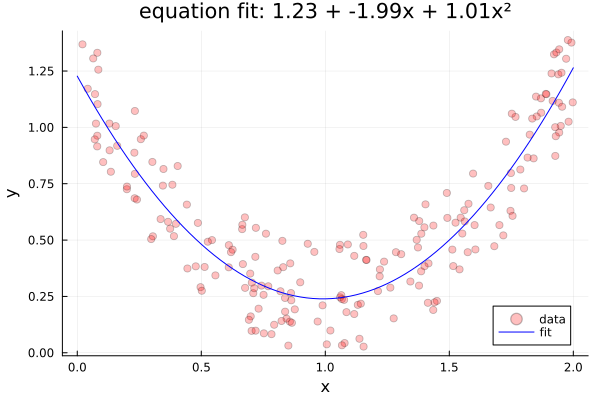

In [4]:
# generate noisy quadratic data
X = 2*rand(200)
y =  1.0 .- 2.0 .* X .+ X.^2 .+ (0.5 .* rand(200))
X = X'

# compute projection
Φ(x) = [1.0, x...,[x[i]*x[j] for i∈1:size(x,1) for j∈1:size(x,1)]...]
X̃ = hcat([Φ(col) for col ∈ eachcol(X)]...)

# fit the parameters
w = (X̃*X̃')\(X̃*y)

# compute projection on test points
Xpred = collect(0:0.025:2)
Xpred = Xpred'
X̃pred = hcat([Φ(col) for col ∈ eachcol(Xpred)]...)

# compute prediction on test points
ypred = X̃pred'*w

# visualize
plot(X', y, 
    seriestype=:scatter,
    color=:red, alpha=0.25, 
    label="data")

plot!(Xpred', ypred, color=:blue, label="fit")
xlabel!("x")
ylabel!("y")
title!("equation fit: $(round(w[1],digits=2)) + $(round(w[2], digits=2))x + $(round(w[3], digits=2))x²")


We see from the above that our linear regression model found a great fit for a 2nd order polynomial when supplied with polynomial features. 

::: {.callout-important collapse=true}

There is a *massive* problem with this method. Our order 2 polynomial map $\phi$ takes us from a $D$ dimenional feature vector to $(D+1)!$ many. This means that as we add more features to our feature map, the dimension of the resulting vector will quickly become prohibitively large. 
    
:::

## Bayesian Regression with Feature Mappings 

Let's update our Bayesian regression scheme to reflect the use of our feature projection map $\phi$. First we define 
\begin{align} 
    \Phi &:= \phi(X) \\ 
    \phi_* &:= \phi(\mathbf{x}_*)
\end{align}

Our predictive distribution therefore becomes
\begin{align}
    p(y_* \vert \mathbf{x}_*, X, \mathbf{y}) &= \mathcal{N}\left(\frac{1}{\sigma_n^2}\phi_*^TA^{-1}\Phi\mathbf{y}, \;\phi_*^TA^{-1}\phi_*\right) \\ 
    A &= \frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}
\end{align}
Great! Now we can do our Bayesian inference with non-linear features given by $\phi$.

Returning to the problem of the rapidly-growing dimensionality of our augmented feature vectors $\phi(\mathbf{x})$, we see that the computational bottleneck is the matrix inversion of $A$ which requires we invert an $N\times N$ matrix. Our prediction (i.e. the mean) involves multiplication on the right by the $n$ dimensional vector $\mathbf{y}$. With that in mind, perhaps we can reformulate the above into an equivalent form using at most an $n\times n$ dimensional matrix...

Let $K:= \Phi^T\Sigma_p\Phi$. Observe the following:
\begin{align} 
    \frac{1}{\sigma_n^2}\Phi(K+\sigma_n^2I) &= \frac{1}{\sigma_n^2}\Phi\left(\Phi^T\Sigma_p\Phi + \sigma_n^2I \right) \\ 
    &= \frac{1}{\sigma_n^2}\Phi\Phi^T\Sigma_p\Phi + \Phi I \\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T \right)\Sigma_p\Phi + \left(\Phi I \Phi^{-1}\Sigma_p^{-1} \right)\Sigma_p\Phi \\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}\right)\Sigma_p\Phi \\ 
    &= A\Sigma_p\Phi
\end{align}

From there we see that 
\begin{align} 
    A^{-1}\frac{1}{\sigma_n^2}\Phi\left(K+\sigma_n^2I\right) &= \Sigma_p\Phi \\ 
    \Rightarrow \frac{1}{\sigma_n^2}A^{-1}\Phi &= \Sigma_p\Phi\left(K + \sigma_n^2I\right)^{-1} \\ 
    \Rightarrow \frac{1}{\sigma_n^2}\phi_*^TA^{-1}\Phi &= \phi_*^T\Sigma_p\Phi\left(K + \sigma_n^2I\right)^{-1}
\end{align} 

For the covariance, we utilize the matrix inversion lemma which states 
\begin{equation}
    (Z + UWV^T)^{-1} = Z^{-1} - Z^{-1}U(W^{-1} + V^TZ^{-1}U)^{-1}V^TZ^{-1}
\end{equation}

With the identification 
\begin{align}
    Z^{-1} &\to \Sigma_p \\ 
    W^{-1} &\to \sigma_n^2I \\ 
    V &\to \Phi \\ 
    U &\to \Phi 
\end{align}
we find 
\begin{align}
    \Sigma_p - \Sigma_p\Phi\left(\Sigma_p + \Phi^T\Sigma_p\Phi \right)^{-1}\Phi^T\Sigma_p  &= \left(\Sigma_p^{-1} + \Phi\frac{1}{\sigma_n^2}I\Phi^T\right)^{-1}\\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}\right)^{-1}  \\ 
    &= A^{-1} 
\end{align}

Thus, we have the equivalent form for our predictive distribution: 
\begin{equation}
    \boxed{p(y_*\vert \mathbf{x}_*, X, \mathbf{y}) =\\ \mathcal{N}\left( \phi_*^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\mathbf{y}, \; \phi_*^T\Sigma_p\phi_* - \phi_*^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\Phi^T\Sigma_p\phi_*\right)}
\end{equation}
where the pesky $N\times N$ term has been replaced by the $n\times n$ matrix $\Phi^T\Sigma_p\Phi$. 

## Kernelization

We now make the the *key* observation that the only matrices that appear in the above expression are 
\begin{align}
    &\Phi^T\Sigma_p\Phi, &\phi_*^T\Sigma_p\phi_* \\ 
    &\phi_*^T\Sigma_p\Phi, &\Phi^T\Sigma_p\phi_*
\end{align}
whose matrix elements we can write abstractly as 
\begin{equation}
    \phi(\mathbf{x})^T\Sigma_p\phi(\mathbf{x}')
\end{equation}

To fit our model, we must determine appropriate values for the symmetric, positive semi-definite covariance matrix $\Sigma_p$ (and $\sigma_n$ too, technically). Instead, we observe that this matrix product is a quadratic form which we can think of as representing an inner product on our transformed vectors: 
\begin{equation}
    K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j)\rangle
\end{equation}
We call the function $k(\mathbf{x},\mathbf{x}')$ the **kernel function** or the *covariance function*.  

All we need to perform the above calculations are the matrix elements of K on our data $\mathcal{D}$ and any test points $\mathbf{x}_*$ we wish to apply our model to. In effect, this means we are free to use feature vectors [**of any dimension, including $\infty$**](https://www.youtube.com/watch?v=XUj5JbQihlU&t=25m53s).[^2]

[^2]: The idea here is that ther kernel vunction represents an inner product over *some* vector space. As it turns out, the RBF kernel corresponds to a an [infinite dimensional feature vector](https://math.stackexchange.com/questions/276707/why-does-a-radial-basis-function-kernel-imply-an-infinite-dimension-map).

There are many choices for the kernel function. One of the most popular is the RBF (radial basis function) kernel, also known as the *squared exponential kernel*: 

\begin{equation}
    k_{\text{rbf}}(\mathbf{x}, \mathbf{x}') := \sigma_f^2\exp(-\frac{1}{2\ell^2}\lvert \mathbf{x}-\mathbf{x}'\rvert^2)
\end{equation}

where $\sigma_f^2$ is the *signal variance* and $\ell$ denotes the similarity length scale. 

For notational convenience, let's define 
\begin{align}
    K &:= k(X,X) \\ 
    K_{**} &:= k(X_*, X_*) \\ 
    K_{*} &:= k(X, X_*)
\end{align}

then, our predictive distribution takes the final, *clean* form
\begin{equation}
    \boxed{p(\mathbf{y}_* \vert X_*, X, \mathbf{y}) = \mathcal{N}\left( K_*^T(K+\sigma_n^2I)^{-1}\mathbf{y},\; K_{**}-K_{*}^T(K+\sigma_n^2I)^{-1}K_*\right)}
\end{equation}

This is the *end-result* of Gaussian Process Regression acheived via the *weight-space view*.

# The Function-space View

So far our approach has been to generalize the standard linear regression model to allow for fitting over a (possibly infinite) basis of features *with* consideration for measurement and model uncertainty (our Bayesian priors). In essence, the idea was to fit *the distribution of all possible weights conditioned on the available training data*, $p(\mathbf{w} \vert X, \mathbf{y})$. A second *equivalent* approach is to instead consider the distribution of all possible model function $f(\mathbf{x})$. By constructing a Bayesian prior of this space, we constrain the space of possible model functions and fit a *distribution over all allowed model functions*, $p(f \vert X, \mathbf{y})$. To do so we will need to develop the abstract machinery of distributions over function spaces. When these distributions are Gaussian in nature, the result is called a *Gaussian process*. 

## Gaussian Processes

By this point, we are all familiar with the Gaussian distribution, aka the Normal distribtion $\mathcal{N}(\mu, \sigma^2)$. This distribution is defined by a mean value $\mu$ and a variance $\sigma^2$. It's *big brother* is the **Multivariate Normal Distribution**, $\mathcal{N}(\mathbf{\mu}, \Sigma)$, described be a vector of means $\mathbf{\mu}}$ and a covariance matrix $\Sigma$. A natural question, then, is can we generalize the concept of the Gaussian distribution from $N$ dimensions to being defined over a continuous field? This question leads naturally to the definition of a **Gaussian Process** 

**Definition:** A *Gaussian Process*, $\mathcal{GP}$, is a collection of random variables for which any finite subset are described by a joint Gaussian distribution. 

To see where this comes from, recall that in our previous derivation, we already made the assumption that all our our data points $\mathcal{D}$ are i.i.d. Gaussian distributed. A gaussian process is the natural extension of this and makes the assumption that the continuous set from which are data are sampled are **so Guassian** that any finite sample will be jointly Gaussian distributed. The term *process* is used to distinguish between finite collections of random variables (distributions) and their continuous counterparts described here.

Because each finite subset of this continuous collection is jointly gaussian, we can completely specify a Gaussian Process with two functions: the mean function $m(\mathcal{x})$ and the covariance function $k(\mathbf{x},\mathbf{x}')$. To denote this, we typically write
\begin{equation}
    f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}'))
\end{equation}

## Bayesian Regression is a Gaussian Process

To see this in action, recall our Bayesian regression model 
\begin{equation}
    f(\mathbf{x} = \phi(\mathbf{x})^T\mathbf{w} \qquad \mathbf{w}\sim\mathcal{N}(\mathbf{0}, \Sigma_p)
\end{equation}
where we have set the prior on $\mathcal{w}$ to have zero mean. 

The mean function is given by the expectation value of our model: 
\begin{equation}
    \mathbb{E}[f(\mathbf{x})] = \phi(\mathbf{x})^T\mathbb{E}[\mathbf{w}] = 0
\end{equation}
and the covariance function is given by 
\begin{equation}
\mathbb{E}[f(\mathbf{x})f(\mathbf{x'})] = \phi(\mathbf{x})^T\mathbb{E}[\mathbf{w}\mathbf{w}^T]\phi(\mathbf{x}') = \phi(\mathbf{x})^T\Sigma_p\phi(\mathbf{x}')
\end{equation}


## Prediction with Noise-free Observations

To repeat the point, the key feature of Gaussian processes is that finite subsets are jointly Gaussian distributed. Thus we can we can split our data into the testpoints $\mathcal{D}=(X,\mathbf{y})$ and testpoints $X_*$ t and treat each collection as joint distributions with the following priors: 

\begin{equation}\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0},\begin{bmatrix} K(X,X) & K(X,X_*) \\ K(X_*,X) & K(X_*,X_*) \end{bmatrix}\right)
\end{equation}

where $\mathbf{f}:= f(X)$ and $\mathbf{f}_* = f(X_*)$. 

## Conditioning the Joint Distribution
To obtain our predictive distribution, $p(\mathbf{f}_* \vert X_*, X, \mathbf{y})$, we *condition the joint prior distribution* on the observations. To see how this works, consider a general joint gaussian distribution given by
\begin{equation}
\begin{bmatrix} x \\ y \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix}\mu_x \\ \mu_y\end{bmatrix},\; \begin{bmatrix} \Sigma_{xx} & \Sigma_{xy} \\ \Sigma_{yx} & \Sigma_{yy} \end{bmatrix}\right)
\end{equation}

define the centered values $\tilde{x} := x-\mu_x$ and $\tilde{y} := x-\mu_y$. Define the intermediate variable 
\begin{equation}
    z := \tilde{x} - A\tilde{y}
\end{equation}

Note that since we've subtracted out the mean we have $\mathbb{E}[\tilde{x}] = \mathbb{E}[\tilde{y}] = \mathbb{E}[z] = 0$

Let's now find $A$... 
\begin{align}
    \mathbb{E}[z\tilde{y}^T] &= \mathbb{E}[(\tilde{x}-A\tilde{y})\tilde{y}^T] \\ 
    &= \mathbb{E}[\tilde{x}\tilde{y}^T - A\tilde{y}\tilde{y}] \\
    &= \mathbb{E}[\tilde{x}\tilde{y}^T] - \mathbb{E}[A\tilde{y}\tilde{y}^T] \\ 
    &= \Sigma_{xy} - A\mathbb{E}[\tilde{y}\tilde{y}^T] \\ 
    &= \Sigma_{xy} - A\Sigma_{yy}
\end{align}

Therefore if we choose $A$ so that $z$ and $\tilde{y}$ are independent and uncorrelated, then $\Sigma_{zy} = \mathbb{E}[z\tilde{y}^T] = 0$. Using this assumption, we find 
\begin{equation}
    0 = \mathbb{E}[z\tilde{y}^T] = \Sigma_{xy}-A\Sigma_{yy} \\ \Rightarrow \boxed{A = \Sigma_{xy}\Sigma_{yy}^{-1}}
\end{equation}

If we now condition $\tilde{x}$ on $\tilde{y}$ (i.e. look at $\tilde{x}$ when $\tilde{y}$ is constant), we find 
\begin{align}
    \mathbb{E}[\tilde{x}\vert\tilde{y}] &= A\tilde{y} + \mathbb{E}[z] \\ 
    &= A\tilde{y} + 0 \\ 
    &= \Sigma_{xy}\Sigma_{yy}^{-1} \\ 
\end{align} 

By manipulating this expression, we can now derive $\mathbb{E}[x\vert y]$ as follows:
\begin{align}
    \mathbb{E}[x\vert\tilde{y}] &= \mathbb{E}[\tilde{x}\vert\tilde{y}] + \mu_x \\ 
    &= \mu_x + \Sigma_{xy}\Sigma_{yy}^{-1}\tilde{y} \\ 
\end{align}
\begin{equation}
\boxed{\mathbb{E}[x\vert y] = \mu_x + \Sigma_{xy}\Sigma_{yy}^{-1}(y-\mu_y)}
\end{equation}

Similarly for the covariance, we have 
\begin{align} 
    \text{Cov}(x \vert y) &= \text{Cov}(\tilde{x}+\mu_x \vert \tilde{y}) \\ 
    &= \text{Cov}(\tilde{x}+\mu_x \vert \tilde{y} + \mu_y) \\ 
    &= \text{Cov}(\tilde{x}\vert(\tilde{y}+\mu_y)) \\ 
    &= \text{Cov}(\tilde{x}\vert \tilde{y}) \\ 
    &= \text{Cov}((z+A\tilde{y})\vert\tilde{y}) \\ 
    &= \text{Cov}(z) + {A\text{Cov}(\tilde{y})} \\ 
    &= \text{Cov}(z) + 0 \\ 
    &= \mathbb{E}[zz^T] \\ 
    &= \mathbb{E}[(\tilde{x}-A\tilde{y})(\tilde{x}-A\tilde{y})^T]\\
    &= \mathbb{E}[\tilde{x}\tilde{x}^T - A\tilde{y}\tilde{x}^T -x(A\tilde{y})^T + A\tilde{y}\tilde{y}^TA^T] \\ 
    &= \Sigma_{xx} - A\Sigma_{yx} - \Sigma_{xy}A^T + A\Sigma_{yy}A^T \\ 
    &= \Sigma_{xx}-(\Sigma_{xy}\Sigma_{yy}^{-1})\Sigma_{yx} - \Sigma_{xy}(\Sigma_{yy}^{-1})^T\Sigma_{xy}^T + \Sigma_{xy}\Sigma_y^{-1}\Sigma_{y}(\Sigma_{y}^{-1})^T\Sigma_{xy}^T \\ 
    &= \Sigma_{xx} - \Sigma_{xy}\Sigma{yy}^{-1}\Sigma_{xy}^T - \Sigma_{xy}(\Sigma_{yy}^{-1})^T\Sigma_{xy}^T + \Sigma_{xy}(\Sigma_{yy}^{-1})^T\Sigma_{xy}^T \\ 
    &= \Sigma_{xx}-\Sigma_{xy}\left[\Sigma_{yy}^{-1} - (\Sigma_{yy}^{-1})^T + (\Sigma_{yy}^{-1})^T \right]\Sigma_{xy}^T \\ 
    &= \Sigma_{xx} - \Sigma_{xy}\Sigma_{yy}^{-1}\Sigma_{yx}
\end{align} 

\begin{equation}
\boxed{\text{Cov}(x \vert y) = \Sigma_{xx} - \Sigma_{xy}\Sigma_{yy}^{-1}\Sigma_{yx}}
\end{equation}

armed with this identity for joint Guassian distributions, we are ready to derive the predictive distribution for Gaussian Process Regression

## Prediction with Gaussian Processes

Applying these results for our gaussian process, we find 
\begin{equation}
    p(\mathbf{f}_* \vert X_*, X, \mathbf{y} = \mathcal{N}\left( K_*^TK^{-1}\mathbf{f},\; K_{**}-K_*^TK^{-1}K_*\right)
\end{equation}

To account for noisy observations, we can augment our correlation function to include a noise offset. The joint distrubtion then becomes: 

\begin{equation}\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0},\begin{bmatrix} K(X,X)-\sigma_n^2I & K(X,X_*) \\ K(X_*,X) & K(X_*,X_*) \end{bmatrix}\right)
\end{equation}

which leads to the predictive distribution
\begin{equation}
    \boxed{p(\mathbf{f}_* \vert X_*, X, \mathbf{y}) = \mathcal{N}\left( K_*^T\left[K + \sigma_n^2 I\right]^{-1}\mathbf{f},\; K_{**}-K_*^T\left[K + \sigma_n^2 I\right]^{-1}K_*\right)}
\end{equation}

# Doing it in Julia

In [5]:
using LinearAlgebra
using Distributions
using Random
using Plots
using Tables 
using MLJBase 
using KernelFunctions 
using AbstractGPs
using Statistics

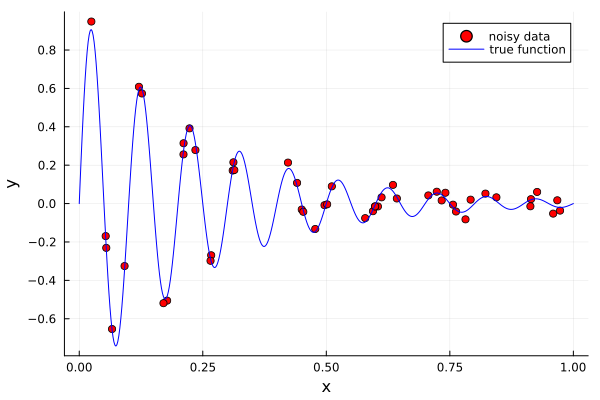

In [6]:
# Make training set

function make_training_data(n, ν)
    xs = reshape(collect(range(0.0, stop=1.0, length=500)), (1,500))
    
    y(x) = (exp(-x/(0.5)^2) * sin(2π*ν*x)) + (0.3)^2*(rand()-0.5)  # this one has some noise
    ytruth(x) = (exp(-x/(0.5)^2) * sin(2π*ν*x)) 
   
    X = Tables.table(rand(1,n)', header=[:x])
    Xtrue = Tables.table(xs', header=[:x])
    
    y = y.(X.x)
    ytrue = ytruth.(Xtrue.x)
    
    return X, y, Xtrue, ytrue
end

X, y, Xtrue, ytrue = make_training_data(50, 10)

scatter(X.x, y, color=:red, label="noisy data")
plot!(Xtrue.x, ytrue, color=:blue, label="true function")
xlabel!("x")
ylabel!("y")

[`KernelFunctions.jl`](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/userguide/) provides a clean interface to create various kernelfunctions and apply them to data to create our matrices `K`.

Due to the fact that kernel functions obey composition laws, we can easily build up complicated Kernels from basic pieces via function composition with $\circ$

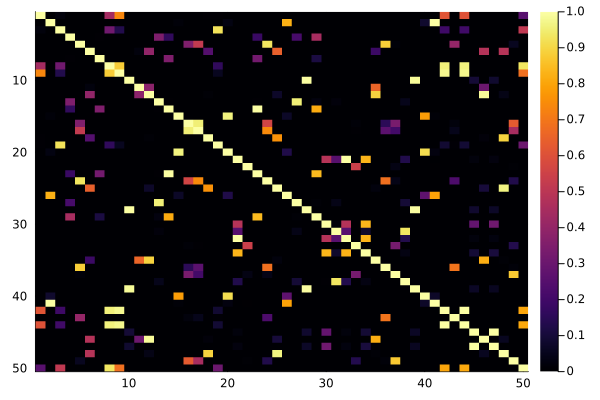

In [7]:
# create kernel function

ℓ = 0.1  # length scale parameter
k = 1.0  * (SqExponentialKernel() ∘ ScaleTransform(1/2ℓ^2))

# test out kernels interface by generating matrix from k
K = kernelmatrix(k, Tables.matrix(X)')  # transpose as we want size (n_features, n_datapoints)

heatmap(K, yflip=true)

Unsurprisingly, there is a lot of activation on the diagonal as for a single datapoint $\mathbf{x}$, we have 
\begin{equation}
    k(\mathbf{x},\mathbf{x}) = \exp\left(-\frac{0}{2\ell^2} \right) = 1.0
\end{equation}

Now that we have our Kernel function, let's construct our Gaussian Process. 

[`AbstractGPs.jl`](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/) provides an excellent way to define Gaussian Processes by supplying mean and kernel functions. We can then sample from our GPs with a simple interface designed to extend the basic functions from `Statistics.jl`. From an `AbstractGP` we can construct a `FiniteGP` by *indexing* into our datasets.

First we construct $f\sim\mathcal{GP}(0, k(\cdot, \cdot))$

In [8]:
# construct an AbstractGP with mean 0 and cov k(x,x')
f = GP(0, k)

GP{AbstractGPs.ConstMean{Int64}, ScaledKernel{TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ScaleTransform{Float64}}, Float64}}(AbstractGPs.ConstMean{Int64}(0), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Scale Transform (s = 49.99999999999999)
	- σ² = 1.0)

From this `AbstractGP`, we can now construct a *FiniteGP*, i.e. a multivariate normal distribution by applying GP to our training data. We include a measurement variance of $\sigma^2 = 0.1$ to account for noisy observations

In [9]:
fₓ = f(Tables.matrix(X)', (0.1)^2)

AbstractGPs.FiniteGP{GP{AbstractGPs.ConstMean{Int64}, ScaledKernel{TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ScaleTransform{Float64}}, Float64}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Diagonal{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ConstMean{Int64}, ScaledKernel{TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ScaleTransform{Float64}}, Float64}}(AbstractGPs.ConstMean{Int64}(0), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Scale Transform (s = 49.99999999999999)
	- σ² = 1.0)
x: SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[[0.5787278383554891], [0.9142048469151632], [0.6349481630131082], [0.09171915630391003], [0.7335198108794088], [0.47760835807275903], [0.02449415371328323], [0.6044400921590919], [0.5943832380403392], [0.31057576909916196]  …  [0.913051019929006],

In [10]:
# let's examine this object 
println(fieldnames(typeof(fₓ)))

fₓ.x.X  # the underlying data 
fₓ.x    # internel data representation as columns for fast computation of kernel matrix
fₓ.Σy   # Data Covariance matrix constructed from the σ² we supplied. Note the sparsity

(:f, :x, :Σy)


50×50 Diagonal{Float64, FillArrays.Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}:
 0.01   ⋅     ⋅     ⋅     ⋅     ⋅    …   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅    0.01   ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅    0.01   ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅    0.01   ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅    0.01   ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅    0.01  …   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    …   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅     ⋅     ⋅     ⋅     ⋅     

Now that we have our Gaussian Process, we can compute the log-marginal likelihood $p(\mathbf{y}\vert X, \theta)$, i.e. the probabity of obtaining the targets given the features, hyperparameters, etc...

In [11]:
logpdf(fₓ, y)  # this is a marginal likelihood

-7.700184939882172

Next, we demonstrate how to compute the posterior Gaussian process (for us that would be $f_*$). First we create the finite gaussian process (a function) which we will use to compute the posterior distribution
\begin{equation}
    p(\mathbf{f}_* \vert X_*, X, \mathbf{y})
\end{equation}

In [12]:
p_fₓ = posterior(fₓ, y)
println(typeof(p_fₓ))

AbstractGPs.PosteriorGP{GP{AbstractGPs.ConstMean{Int64}, ScaledKernel{TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ScaleTransform{Float64}}, Float64}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, Cholesky{Float64, Matrix{Float64}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Vector{Float64}}}}


Now that we have the distribution, we can form our predictions... This can be done a few different ways: 

In [13]:
fₓ_pred = p_fₓ(Tables.matrix(Xtrue)')
ypred = mean(fₓ_pred)
yσ² = var(fₓ_pred)  # variance is diagonal of resulting covariance matrix

500-element Vector{Float64}:
 0.7399969405698197
 0.6745544116473559
 0.6012053216016902
 0.5216117222468406
 0.4382010286577165
 0.3540638974650211
 0.2727409320138179
 0.19790673960059169
 0.1329806849891212
 0.08071357072269503
 0.042813732967400764
 0.019680168275069354
 0.010301206805772735
 ⋮
 0.03407265166349216
 0.05774728658904227
 0.09110947387388468
 0.13471067956710525
 0.18827073610317135
 0.25067899726970433
 0.3201038052855034
 0.39418761362428856
 0.47029407824696645
 0.5457689535207053
 0.6181787610714443
 0.685498828645858

Alternatively, if we instead want a distribution for each datapoint we can compute 
\begin{equation}
    p(\mathbf{y}_x \vert \mathbf{x}_*, X, y)
\end{equation}
When treated as a collection, we can think about each of these representing a marginalized distribution over the test points $\mathbf{x}_*$ and hence, we call `marginals()`

In [14]:
p_pred = marginals(fₓ_pred)
println(p_pred[1])

y_pred = mean.(p_pred);
y_σ = std.(p_pred);

Normal{Float64}(μ=0.45719064373766344, σ=0.8602307484447529)


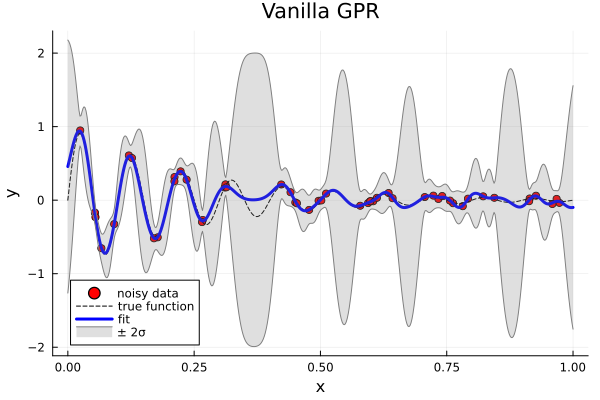

In [15]:
p1 = plot(X.x, y, seriestype=:scatter, color=:red, label="noisy data")
plot!(Xtrue.x, ytrue, color=:black, linestyle=:dash, label="true function")
plot!(Xtrue.x, y_pred, color=:blue, linewidth=3, label="fit" )
plot!(Xtrue.x, y_pred .+ 2y_σ, c=:gray, label="")
plot!(Xtrue.x, y_pred .- 2y_σ, fillrange = y_pred .+ 2y_σ, fillalpha=0.25, color=:gray, label="± 2σ")
xlabel!("x")
ylabel!("y")
title!("Vanilla GPR")

### Summary: 

So far we have shown how to: 

1. Build a kernel function $k(\cdot, \cdot)$ via composition using `KernelFunctions.jl`
2. Construct an a Gaussian Process $f\sim\mathcal{GP}$ abstractly using `AbstractGPs.jl`
3. Construct a finite representation of our GP, $f_x$, over training data
4. Construct a posterior Gaussian Process from $f_x$ and our training targets $\mathbf{y}$. 
5. Construct a finite representation of the posterior GP applied to our prediction data (here `Xtrue`). 
6. Sample this final distribution to obatin a prediction via `mean()` and variances via `var()`. Alternatively, we can obtain a multivariate normal distribution for each point by calling `marginals()`. 

# Fitting the Gaussian Process

You may think we have *already* fit the Guassian process however, we were forced to choose values for both $\ell$ and $\sigma^2$. How can we optimally select the ideal hyperparameters for our Gaussian Process? This leads us into the realm of [Bayesian Model Selection](https://gaussianprocess.org/gpml/chapters/RW5.pdf)

## Bayesian Model Selection
There are several levels of parameters in machine learning. At the lowest level, we have the model weights $\mathbf{w}$. Above that, we have model hyperparameters, $\theta$. At the top we have model structure $\mathcal{H}$. In our Bayesian framework, we can consider distributions defined at each of these levels. At the bottom, we have 
\begin{equation}
    p(\mathbf{w} \vert X, \mathbf{y}, \theta, \mathcal{H}_i) = \frac{p(\mathbf{y} \vert X, \mathbf{w}, \theta, \mathcal{H}_i) p(\mathbf{w}\vert \theta, \mathcal{H}_i) }{p(\mathbf{y}\vert X, \theta, \mathcal{H}_i)}
\end{equation}

::: {.callout-note collapse=true}

If this looks confusing, consider Bayes rule for 3 events $R, H, S$. We have: 
\begin{align}
    P(R \vert H, S) &= \frac{P(R,H,S)}{P(H,S)} \\
    &= \frac{P(H \vert R, S)P(R, S)}{P(H,S)}\\ 
    &= \frac{P(H \vert R, S)P(R\vert S)P(S)}{P(H\vert S)P(S)} \\ 
    &= \frac{P(H \vert R, S)P(R\vert S)}{P(H\vert S)}
\end{align}
    
To get the result, just think of $\theta$ and $\mathcal{H}_i$ as a single *event* and translate the above to distribution functions.

[stack exchange link](https://math.stackexchange.com/questions/1281454/bayes-rule-with-3-variables)
:::

The prior $p(\mathbf{w}\vert \theta, \mathcal{H}_i)$ encodes any knowledge we have about the parameters prior to seeing the data. The denominator is the *marginal likelihood* and is given by 
\begin{equation}
    p(\mathbf{y}\vert X, \theta, \mathcal{H}_i) = \int d\mathbf{w}\; p(\mathbf{y} \vert X, \mathbf{w}, \theta, \mathcal{H}_i)p(\mathbf{w}\vert \theta, \mathcal{H}_i)
\end{equation}

The next level up is to express the distribution of hyper-parameters $\theta$: 
\begin{equation}
    p(\theta \vert X, \mathbf{y}, \mathcal{H}_i) = \frac{p(\mathbf{y}\vert X, \theta, \mathcal{H}_i)p(\theta \vert \mathcal{H}_i)}{p(\mathbf{y}\vert X, \mathcal{H}_i)}
\end{equation}
Here $p(\theta \vert \mathcal{H}_i)$ is called the *hyper-prior*. Similarly, the normalization constant is given by 
\begin{equation}
    p(\mathbf{y}\vert X,\mathcal{H}_i) = \int d\theta \; p(\mathbf{y}\vert X, \theta, \mathcal{H}_i)p(\theta \vert \mathcal{H}_i)
\end{equation}

Finally, at the top level we have the set of possible model structures $\{\mathcal{H}_i\}$. This leads to
\begin{equation}
    p(\mathcal{H}_i \vert X, \mathbf{y}) = \frac{p(\mathbf{y} \vert X, \mathcal{H}_i)p(\mathcal{H}_i)}{p(\mathbf{y}\vert X)}
\end{equation}
with normlization constant
\begin{equation}
 p(\mathbf{y}\vert X) = \sum_i p(\mathbf{y} \vert X, \mathcal{H}_i)p(\mathcal{H}_i)
\end{equation}

Depending on the model details, these integrals may be intractible to approximations or Monte Carlo methods. Since we rarely have sufficient knowledge to form a hyperparameter prior, one often attempts to maximize the marginal likelihood $p(\mathbf{y} \vert X, \theta, \mathcal{H}_i)$ with respect to the hyperparameters $\theta$ instead. This is known as Type II Maximium Likelihood Estimation. 

In the case of Gaussian Process Regression, we are once again saved by the fact that every piece has a convenient functional from resulting in analytically tractible integrals for the marginal likelihood function. We find 
\begin{equation}
    \ln p(\mathbf{y}\vert X, \theta) = -\frac{1}{2}\mathbf{y}^T(K_f + \sigma_n^2 I)^{-1}\mathbf{y} - \frac{1}{2}\ln\lvert K_f + \sigma_n^2 I \rvert -\frac{n}{2}\ln(2\pi)
\end{equation}

::: {.callout-note collapse=true} 

We should add a derivation of this when possible. It's just a big 'ol nasty integral. 

:::

Let's try this out in code! See [this section](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/0-intro-1d/#Exact-Gaussian-Process-Inference) from the `AbstractGPs.jl` docs...

In [16]:
using Optim

In [96]:
# helpuer functions to insure parameters are positive
softplus(x) = log(1+exp(x))
softplusinv(x) = log(exp(x)-1)

softplusinv (generic function with 1 method)

We want to maximize the log-marginal-likelihood and therefore want to minimize minus that quantitty:

In [18]:
# define loss function
function loss_function(x,y)
    function negativelogmarginallikelihood(params)
        kernel = softplus(params[1]) * (SqExponentialKernel() ∘ ScaleTransform(softplus(params[2])))
         f = GP(kernel)
        fx = f(x, softplus(params[3]))
        return -logpdf(fx, y)
    end
    return negativelogmarginallikelihood
end

loss_function (generic function with 1 method)

In [19]:
# prefactor, length parameter, measurement variance
θ₀ = [1.0, 1/(2ℓ^2), (0.25)^2]

3-element Vector{Float64}:
  1.0
 49.99999999999999
  0.0625

In [20]:
# default option uses finite diff methods
opt = Optim.optimize(loss_function(Tables.matrix(X)', y), θ₀, LBFGS(); autodiff=:forward)  
params_best = opt.minimizer

softplus.(params_best)

3-element Vector{Float64}:
  0.1206544051219394
 37.409897810113726
  0.000582519141662673

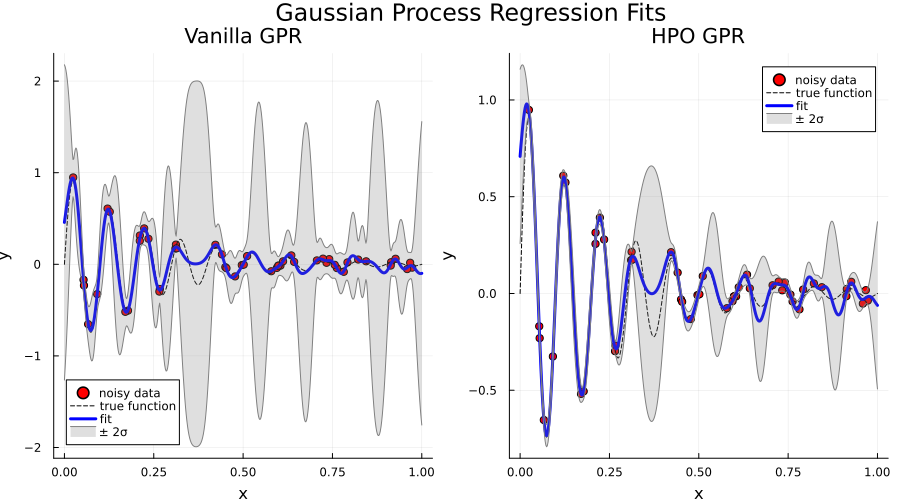

In [30]:
kernel_best = softplus(params_best[1]) * (SqExponentialKernel() ∘ ScaleTransform(softplus(params_best[2])))
f = GP(kernel_best)

fₓ = f(Tables.matrix(X)', softplus(params_best[3]))
p_fₓ = posterior(fₓ, y)
fₓ_pred = p_fₓ(Tables.matrix(Xtrue)')
p_pred = marginals(fₓ_pred)
y_pred = mean.(p_pred);
y_σ = std.(p_pred);

p2 = plot(X.x, y, seriestype=:scatter, color=:red, label="noisy data")
plot!(Xtrue.x, ytrue, color=:black, linestyle=:dash, label="true function")
plot!(Xtrue.x, y_pred, color=:blue, linewidth=3, label="fit" )
plot!(Xtrue.x, y_pred .+ 2y_σ, c=:gray, label="")
plot!(Xtrue.x, y_pred .- 2y_σ, fillrange = y_pred .+ 2y_σ, fillalpha=0.25, color=:gray, label="± 2σ")
xlabel!("x")
ylabel!("y")
title!("HPO GPR")

plot(p1, p2, layout=(1,2), size=(900, 500), plot_title="Gaussian Process Regression Fits")

Excellent! Now that we have the hang of it, let's try another fit for a function of two variables. 

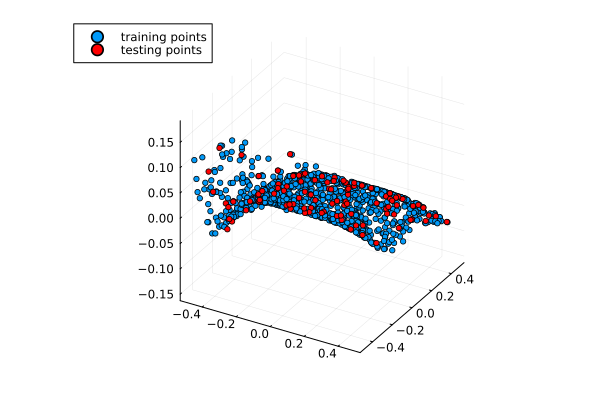

In [157]:
n=1000
xs = (rand(n,2) .- 0.5)
x₁ = xs[:,1]
x₂ = xs[:,2]
y = x₁.^5 .+ x₂.^4 .- x₁.^4 .- x₂.^3 

Xtrain = Tables.table(xs[1:Int(0.9*n), :], header=[:x₁, :x₂])
Xtest = Tables.table(xs[Int(0.9*n)+1:end, :], header=[:x₁, :x₂])

ytrain = y[1:Int(0.9*n)]
ytest = y[Int(0.9*n)+1:end]

scatter(Xtrain.x₁, Xtrain.x₂, ytrain, ms=3, label="training points")
scatter!(Xtest.x₁, Xtest.x₂, ytest, color=:red, ms=3, label="testing points")

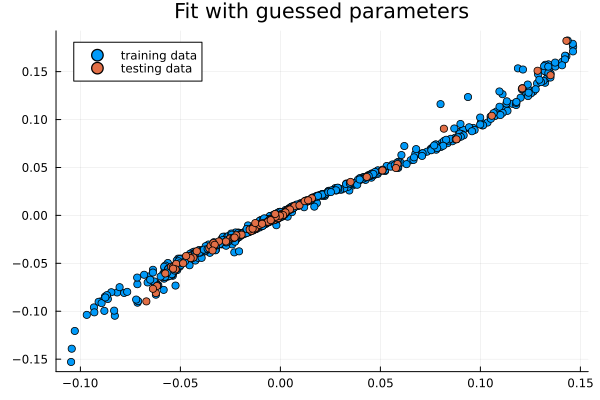

In [162]:
# this is me just trying to manuallyfind some good parameters
σf² = 0.25
ℓ = 0.3
σn² = 0.25

k = σf²  * (SqExponentialKernel() ∘ ScaleTransform(1/2ℓ^2))

# test out kernels interface by generating matrix from k
K = kernelmatrix(k, Tables.matrix(Xtrain)')  # transpose as we want size (n_features, n_datapoints)

f = GP(0, k)
fₓ = f(Tables.matrix(Xtrain)', σn²)
logpdf(fₓ, ytrain)  # this is a marginal likelihood

p_fₓ = posterior(fₓ, ytrain)


fₓ_pred_train = p_fₓ(Tables.matrix(Xtrain)')
ypred_train = mean(fₓ_pred_train)
yσ²_train = var(fₓ_pred_train)  # variance is diagonal of resulting covariance matrix

fₓ_pred_test = p_fₓ(Tables.matrix(Xtest)')
ypred_test = mean(fₓ_pred_test)
yσ²_test = var(fₓ_pred_test)  # variance is diagonal of resulting covariance matrix

pf1 = scatter(ypred_train, ytrain, label="training data")
scatter!(ypred_test, ytest, label="testing data")
title!("Fit with guessed parameters")



we need a way to intelligently initialize the outputs. See [this post](https://infallible-thompson-49de36.netlify.app/) for ideas

In [163]:

θ_lower = [1e-5, 1e-5, 1e-5]
θ_upper = [Inf, Inf, Inf]
θ₀ = [0.25, 0.3, 0.25]

# define loss function
function loss_function(x,y)
    function negativelogmarginallikelihood(params)
        kernel = params[1] * (SqExponentialKernel() ∘ ScaleTransform(params[2]))
         f = GP(kernel)
        fx = f(x, params[3])
        return -logpdf(fx, y)
    end
    return negativelogmarginallikelihood
end


# default option uses finite diff methods
opt = Optim.optimize(loss_function(Tables.matrix(Xtrain)', ytrain), θ_lower, θ_upper, θ₀, Fminbox(LBFGS()); autodiff=:forward)  
params_best = opt.minimizer

# softplus.(params_best)

3-element Vector{Float64}:
 7.44878713782739
 1.062150755934373
 1.0000000000000003e-5

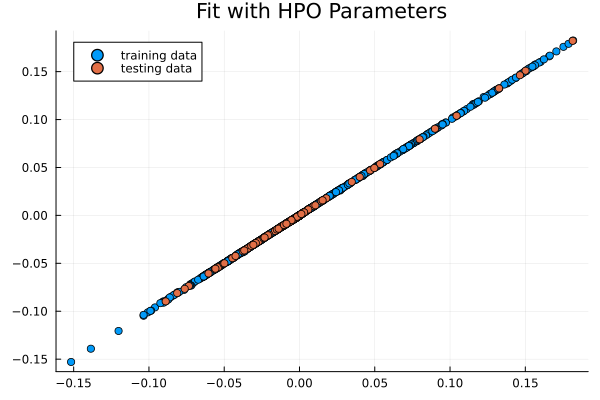

In [165]:
kernel_best = params_best[1] * (SqExponentialKernel() ∘ ScaleTransform(params_best[2]))
f = GP(kernel_best)

fₓ = f(Tables.matrix(Xtrain)', params_best[3])
p_fₓ = posterior(fₓ, ytrain)

# compute 
fₓ_pred = p_fₓ(Tables.matrix(Xtest)')
p_pred = marginals(fₓ_pred)
y_pred = mean.(p_pred);
y_σ = std.(p_pred);


fₓ_pred_train = p_fₓ(Tables.matrix(Xtrain)')
ypred_train = mean(fₓ_pred_train)
yσ²_train = var(fₓ_pred_train)  # variance is diagonal of resulting covariance matrix

fₓ_pred_test = p_fₓ(Tables.matrix(Xtest)')
ypred_test = mean(fₓ_pred_test)
yσ²_test = var(fₓ_pred_test)  # variance is diagonal of resulting covariance matrix

pf2 = scatter(ypred_train, ytrain, label="training data")
scatter!(ypred_test, ytest, label="testing data")
title!("Fit with HPO Parameters")

In [175]:
marginals(fₓ_pred_train)

900-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.010400795687473874, σ=0.00035037346174344536)
 Normal{Float64}(μ=-0.012172544294344334, σ=0.0003825535966581155)
 Normal{Float64}(μ=-0.003692183680868766, σ=0.00036326742814205324)
 Normal{Float64}(μ=0.0030344804249580193, σ=0.00035299693729260947)
 Normal{Float64}(μ=-0.008193057695734751, σ=0.0003798955083331059)
 Normal{Float64}(μ=0.15378105970739853, σ=0.0008182225299438748)
 Normal{Float64}(μ=-0.038238358903527114, σ=0.0005019506938365845)
 Normal{Float64}(μ=-0.05854285968462136, σ=0.0007776923621838775)
 Normal{Float64}(μ=-0.01249912826324362, σ=0.0003932095861878094)
 Normal{Float64}(μ=0.057902235075289354, σ=0.00041030597882028684)
 Normal{Float64}(μ=0.0011632400992311887, σ=0.00034108646783589946)
 Normal{Float64}(μ=-0.018200111100668437, σ=0.0004837689169881995)
 Normal{Float64}(μ=-0.002522870589473314, σ=0.0003555895502088072)
 ⋮
 Normal{Float64}(μ=-0.05043878931292056, σ=0.0004920300553927884)
 Normal{Float64}(μ=-0.01